# Построение модели определения стоимости автомобиля

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import time
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
warnings.filterwarnings("ignore")

## Подготовка данных

In [2]:
try:
    data = pd.read_csv('/datasets/autos.csv')     
except:
    data = pd.read_csv('c:/Users/User/Downloads/autos.csv')

Посмотрим на данные

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
data.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
Repaired             0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

Проверка числовых признаков на наличие аномалий

In [6]:
columns_numeric = ['Price', 'RegistrationYear', 'Power', 'Kilometer']

def numeric(data, columns_numeric):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    for column, ax in zip(columns_numeric, axes.ravel()):
        ax.set_title(column)
        sns.distplot(data[column], ax=ax)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    for column, ax in zip(columns_numeric, axes.ravel()):
        ax.set_title(column)
        sns.boxplot(data[column], ax=ax)

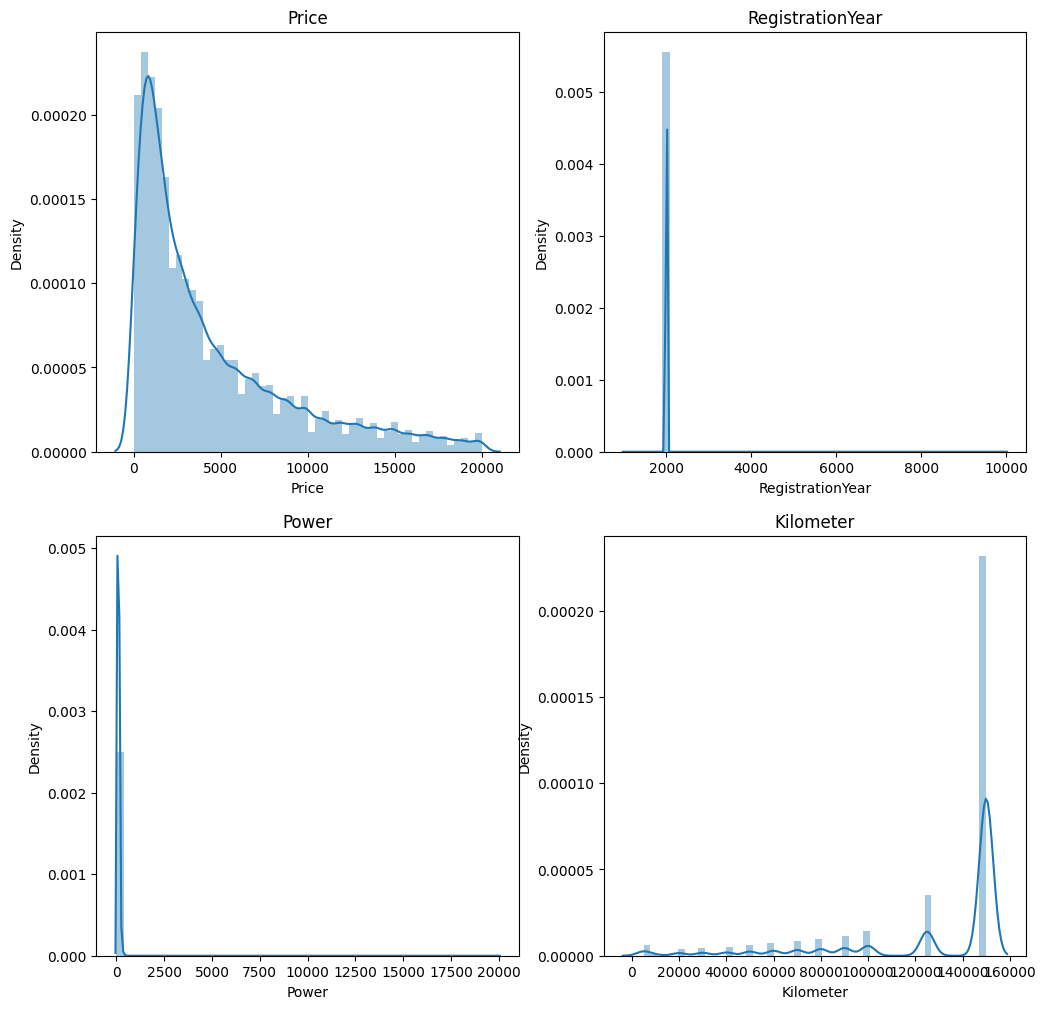

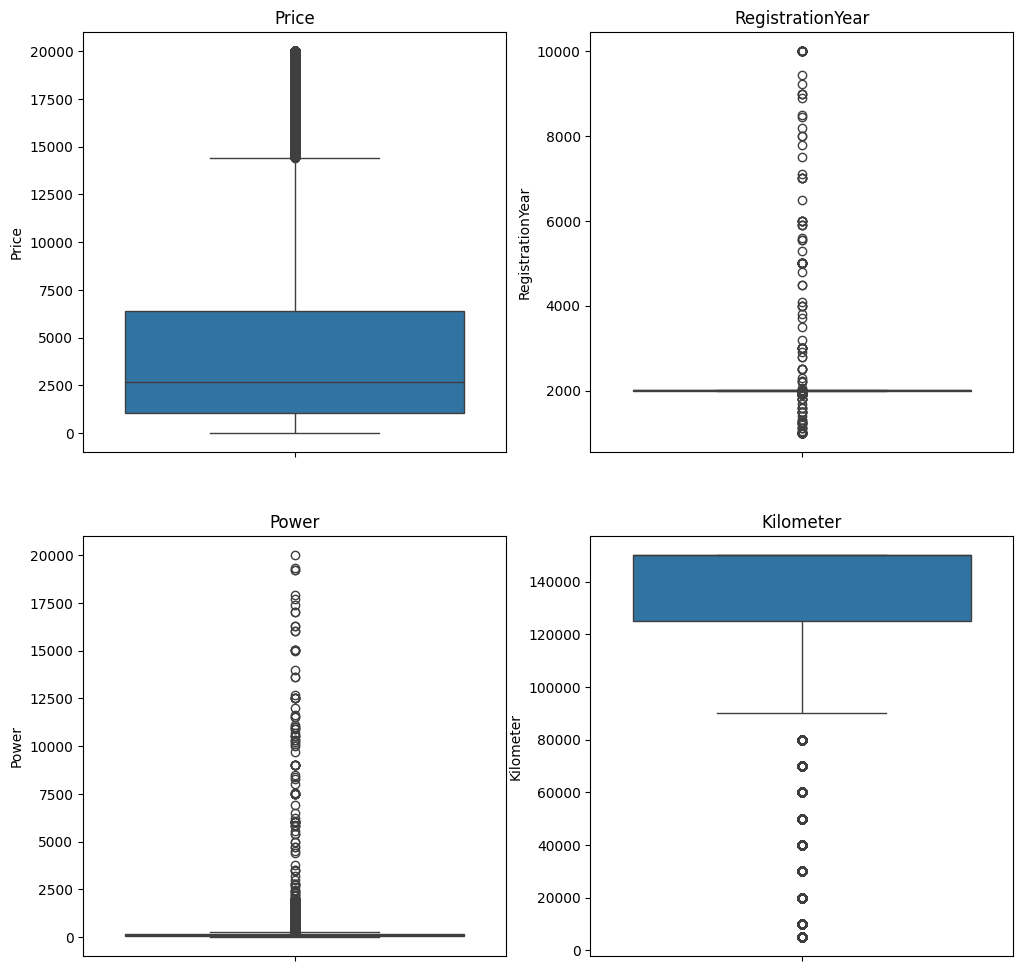

In [7]:
numeric(data, columns_numeric)

Сократим дата фрейм до нужных столбцов.

In [8]:
filtred_autos_data = data[['VehicleType', 
                         'Gearbox', 
                         'Power',
                         'Kilometer',
                         'FuelType',
                         'Brand',
                         'Repaired',
                         'RegistrationYear',
                         'Model',
                         'Price']]
filtred_autos_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       316879 non-null  object
 1   Gearbox           334536 non-null  object
 2   Power             354369 non-null  int64 
 3   Kilometer         354369 non-null  int64 
 4   FuelType          321474 non-null  object
 5   Brand             354369 non-null  object
 6   Repaired          283215 non-null  object
 7   RegistrationYear  354369 non-null  int64 
 8   Model             334664 non-null  object
 9   Price             354369 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


Проверим наполнение целевого признака Price.

In [9]:
filtred_autos_data['Price'].value_counts()

Price
0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
1368         1
233          1
11080        1
16340        1
10985        1
Name: count, Length: 3731, dtype: int64

Видно, что существует 10772 записи без цены. Удалим их и проверим распределение цены на гистограмме.

count    343597.000000
mean       4555.121974
std        4515.058553
min           1.000000
25%        1200.000000
50%        2890.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

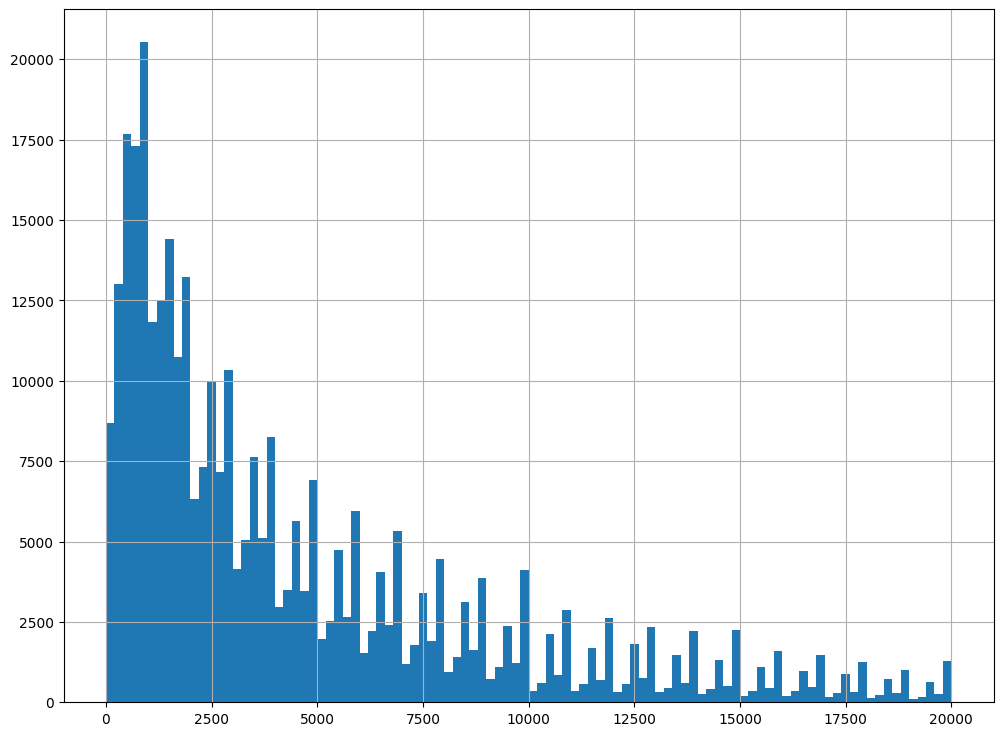

In [10]:
filtred_autos_data = filtred_autos_data.query('Price > 0')
filtred_autos_data['Price'].hist(bins=100, figsize=(12,9))
filtred_autos_data['Price'].describe()

Выделим квантили 5% и 80%.

In [11]:
filtred_autos_data['Price'].quantile([.05, 0.8])

0.05     350.0
0.80    7800.0
Name: Price, dtype: float64

Стоимость 350 евро это минимальная цена для продажи поддержанного авто. Выбор 80% квантиля обоснован болльшими выбросами после 7500 евро.

In [12]:
filtred_autos_data = filtred_autos_data.query('350 <= Price <= 7800')
filtred_autos_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 259798 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       233267 non-null  object
 1   Gearbox           246646 non-null  object
 2   Power             259798 non-null  int64 
 3   Kilometer         259798 non-null  int64 
 4   FuelType          236972 non-null  object
 5   Brand             259798 non-null  object
 6   Repaired          206998 non-null  object
 7   RegistrationYear  259798 non-null  int64 
 8   Model             246358 non-null  object
 9   Price             259798 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 21.8+ MB


Узнаем максимальную дату скачивания анкеты автомобиля.

In [13]:
date = pd.to_datetime(data['DateCrawled'])
date.max()

Timestamp('2016-04-07 14:36:58')

Даты регистрации после 2016 года некорректны и машины появились не раньше 1900 года. Отсечем ненужные года и промотрим левые выбросы.

count    247788.000000
mean       2001.539179
std           6.112319
min        1910.000000
25%        1998.000000
50%        2002.000000
75%        2005.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

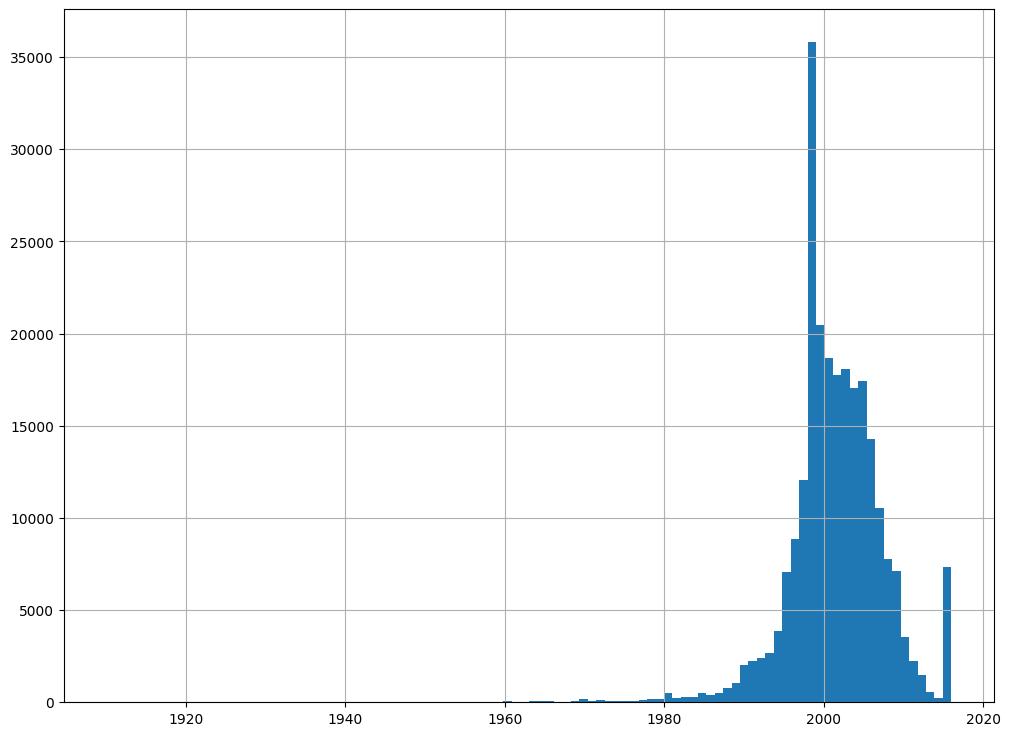

In [14]:
filtred_autos_data = filtred_autos_data.query('1899 < RegistrationYear < 2017')
filtred_autos_data['RegistrationYear'].hist(bins=100, figsize=(12,9))
filtred_autos_data['RegistrationYear'].describe()

Удалим аномальные значение в столбце RegistrationYear

count    247665.000000
mean       2001.567440
std           5.968335
min        1960.000000
25%        1998.000000
50%        2002.000000
75%        2005.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

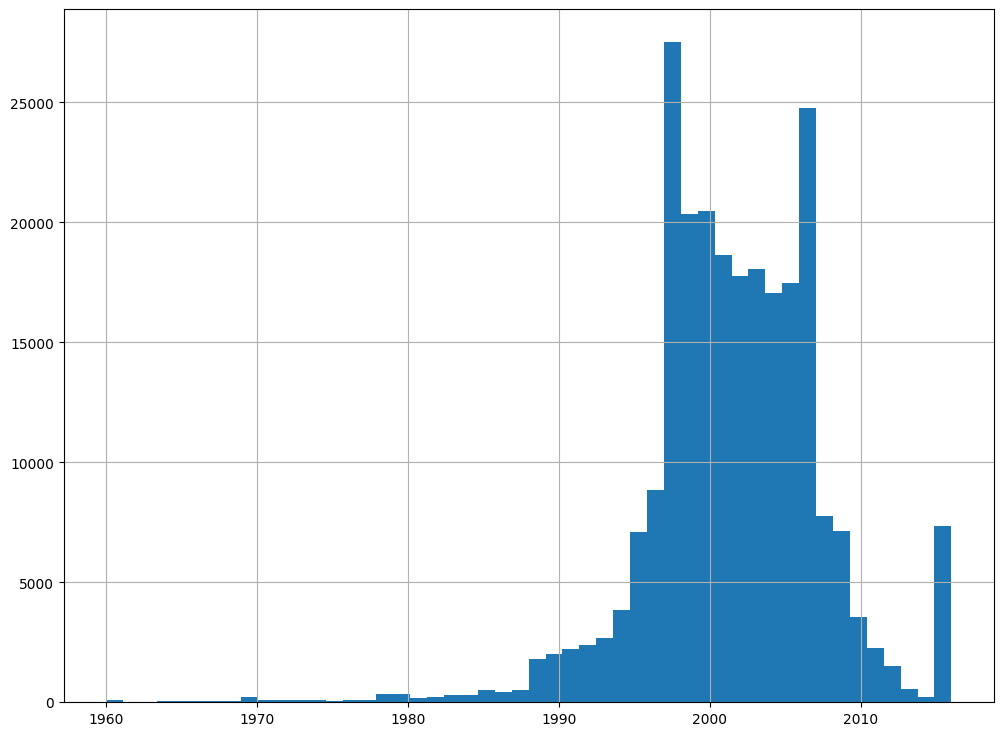

In [15]:
filtred_autos_data = filtred_autos_data.query('1959 < RegistrationYear < 2017')
filtred_autos_data['RegistrationYear'].hist(bins=50, figsize=(12,9))
filtred_autos_data['RegistrationYear'].describe()

Проведем замену NaN в Gearbox, Repaired и Model.

In [16]:
filtred_autos_data.fillna({'Gearbox':'manual', 
                           'Repaired':'yes',
                           'Model':'unknown'},
                          inplace=True)
filtred_autos_data.isna().mean()

VehicleType         0.058640
Gearbox             0.000000
Power               0.000000
Kilometer           0.000000
FuelType            0.073575
Brand               0.000000
Repaired            0.000000
RegistrationYear    0.000000
Model               0.000000
Price               0.000000
dtype: float64

Оценим количество пропущенных значений относительно всех значений в столбце VehicleType

In [17]:
print(filtred_autos_data['VehicleType'].value_counts())
filtred_autos_data['VehicleType'].isna().sum()

VehicleType
sedan          67609
small          66486
wagon          47300
bus            21087
convertible    12662
coupe          10311
suv             5237
other           2450
Name: count, dtype: int64


14523

Выполним замену NaN в соотвествии с популярным типом кузова для каждого бренда.

In [18]:
vehicle_type_pivot_table = filtred_autos_data.pivot_table(index=['VehicleType'], 
                                                          columns=['Brand'],
                                                          values=['Price'],
                                                          aggfunc=['count'])
display(vehicle_type_pivot_table)
filtred_autos_data[filtred_autos_data['Brand'] == 'alfa_romeo']['VehicleType'].value_counts()

count                                                     \
                 Price                                                      
Brand       alfa_romeo    audi      bmw chevrolet chrysler citroen  dacia   
VehicleType                                                                 
bus                NaN    10.0      4.0      98.0    370.0  1040.0   15.0   
convertible      111.0   667.0   1636.0       6.0    195.0    96.0    NaN   
coupe            180.0   651.0   2570.0      45.0     17.0   137.0    NaN   
other             10.0    83.0    187.0      18.0      6.0    95.0    5.0   
sedan            777.0  7828.0  11309.0     146.0    205.0   538.0   97.0   
small            185.0   933.0    324.0     574.0     12.0  1372.0  178.0   
suv                NaN    18.0    189.0     146.0     12.0     8.0   46.0   
wagon            388.0  6422.0   4997.0      83.0    183.0   497.0  227.0   

                                     ...                          \
                                     ...                           
Brand       daewoo daihatsu    fiat  ...    seat   skoda   smart   
VehicleType                          ...                           
bus           26.0     31.0   707.0  ...   485.0   158.0     1.0   
convertible    1.0      8.0   257.0  ...     NaN     3.0   988.0   
coupe          2.0      NaN   151.0  ...    64.0     6.0   318.0   
other          5.0      9.0   151.0  ...    47.0    21.0     8.0   
sedan         87.0     35.0   796.0  ...  1220.0   694.0    26.0   
small        247.0    439.0  4520.0  ...  2621.0   930.0  3099.0   
suv            1.0     46.0    17.0  ...     1.0     7.0     NaN   
wagon         36.0     16.0   370.0  ...   215.0  1763.0     9.0   

                                                                             
                                                                             
Brand       sonstige_autos subaru suzuki  toyota trabant volkswagen   volvo  
VehicleType                                                                  
bus                  140.0   16.0   27.0   341.0     NaN     5936.0     NaN  
convertible          161.0    NaN   32.0    47.0    30.0     2029.0    35.0  
coupe                 79.0    3.0    4.0   178.0     2.0      740.0    50.0  
other                167.0    5.0   10.0    15.0     4.0      586.0     NaN  
sedan                257.0   99.0  131.0   735.0   170.0    14847.0   487.0  
small                166.0   99.0  810.0  1475.0    49.0    15294.0     6.0  
suv                  174.0   42.0  557.0   252.0     NaN      247.0    30.0  
wagon                104.0  241.0   84.0   449.0    66.0     9704.0  1655.0  

[8 rows x 40 columns]

VehicleType
sedan          777
wagon          388
small          185
coupe          180
convertible    111
other           10
Name: count, dtype: int64

In [19]:
vehicle_type_pivot_table = vehicle_type_pivot_table['count']['Price']
vehicle_type_pivot_table

Brand,alfa_romeo,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,daihatsu,fiat,...,seat,skoda,smart,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo
VehicleType,,,,,,,,,,,,,,,,,,,,,
bus,NaN,10.0,4.0,98.0,370.0,1040.0,15.0,26.0,31.0,707.0,...,485.0,158.0,1.0,140.0,16.0,27.0,341.0,NaN,5936.0,NaN
convertible,111.0,667.0,1636.0,6.0,195.0,96.0,NaN,1.0,8.0,257.0,...,NaN,3.0,988.0,161.0,NaN,32.0,47.0,30.0,2029.0,35.0
coupe,180.0,651.0,2570.0,45.0,17.0,137.0,NaN,2.0,NaN,151.0,...,64.0,6.0,318.0,79.0,3.0,4.0,178.0,2.0,740.0,50.0
other,10.0,83.0,187.0,18.0,6.0,95.0,5.0,5.0,9.0,151.0,...,47.0,21.0,8.0,167.0,5.0,10.0,15.0,4.0,586.0,NaN
sedan,777.0,7828.0,11309.0,146.0,205.0,538.0,97.0,87.0,35.0,796.0,...,1220.0,694.0,26.0,257.0,99.0,131.0,735.0,170.0,14847.0,487.0
small,185.0,933.0,324.0,574.0,12.0,1372.0,178.0,247.0,439.0,4520.0,...,2621.0,930.0,3099.0,166.0,99.0,810.0,1475.0,49.0,15294.0,6.0
suv,NaN,18.0,189.0,146.0,12.0,8.0,46.0,1.0,46.0,17.0,...,1.0,7.0,NaN,174.0,42.0,557.0,252.0,NaN,247.0,30.0
wagon,388.0,6422.0,4997.0,83.0,183.0,497.0,227.0,36.0,16.0,370.0,...,215.0,1763.0,9.0,104.0,241.0,84.0,449.0,66.0,9704.0,1655.0


Заполним словарь брендов и популярных типов машин и заполним пропуски по столбцу VehicleType.

In [20]:
filtred_autos_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 247665 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       233142 non-null  object
 1   Gearbox           247665 non-null  object
 2   Power             247665 non-null  int64 
 3   Kilometer         247665 non-null  int64 
 4   FuelType          229443 non-null  object
 5   Brand             247665 non-null  object
 6   Repaired          247665 non-null  object
 7   RegistrationYear  247665 non-null  int64 
 8   Model             247665 non-null  object
 9   Price             247665 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 20.8+ MB


In [21]:
filtred_autos_data.fillna({'VehicleType':0},inplace=True)

def fillna_by_brand(row, row_number, vehicle_type_pivot_table):
    brand = row[5]
    fill_value = row[row_number]
    if row[row_number] == 0:
        fill_value = vehicle_type_pivot_table[brand].idxmax()
    return fill_value

filtred_autos_data['VehicleType'] = filtred_autos_data.apply(
                                fillna_by_brand, 
                                args=[0, vehicle_type_pivot_table],
                                axis=1)
display(filtred_autos_data['VehicleType'].isna().sum())
filtred_autos_data['VehicleType'].value_counts()

0

VehicleType
small          76545
sedan          71693
wagon          47556
bus            21144
convertible    12662
coupe          10330
suv             5285
other           2450
Name: count, dtype: int64

Заполним пропуски в FuelType по похожему принципу.

In [22]:
filtred_autos_data['FuelType'].value_counts()
fuel_type_pivot_table = filtred_autos_data.pivot_table(index=['FuelType'], 
                                                          columns=['Brand'],
                                                          values=['Price'],
                                                          aggfunc=['count'])
fuel_type_pivot_table = fuel_type_pivot_table['count']['Price']
display(fuel_type_pivot_table)

filtred_autos_data.fillna({'FuelType':0},inplace=True)

filtred_autos_data['FuelType'] = filtred_autos_data.apply(
                                fillna_by_brand, 
                                args=[4, vehicle_type_pivot_table],
                                axis=1)
display(filtred_autos_data['FuelType'].isna().sum())
filtred_autos_data['FuelType'].value_counts()

Brand,alfa_romeo,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,daihatsu,fiat,...,seat,skoda,smart,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo
FuelType,,,,,,,,,,,,,,,,,,,,,
cng,NaN,1.0,6.0,4.0,NaN,7.0,2.0,NaN,NaN,63.0,...,NaN,4.0,2.0,NaN,2.0,NaN,NaN,NaN,125.0,14.0
electric,NaN,1.0,3.0,NaN,NaN,NaN,NaN,NaN,1.0,2.0,...,NaN,NaN,1.0,16.0,NaN,NaN,NaN,NaN,1.0,NaN
gasoline,480.0,6502.0,5073.0,66.0,264.0,1181.0,98.0,1.0,4.0,1243.0,...,1229.0,1145.0,807.0,297.0,10.0,145.0,679.0,1.0,16655.0,582.0
hybrid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,1.0,NaN,1.0,NaN,NaN,NaN,35.0,NaN,5.0,NaN
lpg,30.0,356.0,606.0,139.0,77.0,63.0,35.0,23.0,5.0,64.0,...,56.0,48.0,3.0,58.0,25.0,18.0,18.0,NaN,454.0,100.0
other,NaN,2.0,5.0,NaN,NaN,2.0,NaN,1.0,NaN,3.0,...,NaN,NaN,1.0,16.0,NaN,1.0,NaN,31.0,14.0,2.0
petrol,1124.0,9465.0,14948.0,884.0,642.0,2499.0,424.0,374.0,564.0,5496.0,...,3333.0,2333.0,3604.0,784.0,453.0,1457.0,2736.0,242.0,31839.0,1507.0


0

FuelType
petrol      162858
gasoline     61661
small        12152
sedan         5523
lpg           4241
cng            431
wagon          390
other          115
hybrid          83
bus             74
suv             62
electric        54
coupe           21
Name: count, dtype: int64

In [23]:
filtred_autos_data.isna().mean()

VehicleType         0.0
Gearbox             0.0
Power               0.0
Kilometer           0.0
FuelType            0.0
Brand               0.0
Repaired            0.0
RegistrationYear    0.0
Model               0.0
Price               0.0
dtype: float64

Пропуски убраны. Осталось заняться некорректнымми значениями в столбце Power.

count    247451.000000
mean         98.693652
std          54.774902
min           0.000000
25%          67.000000
50%         101.000000
75%         131.000000
max        1000.000000
Name: Power, dtype: float64

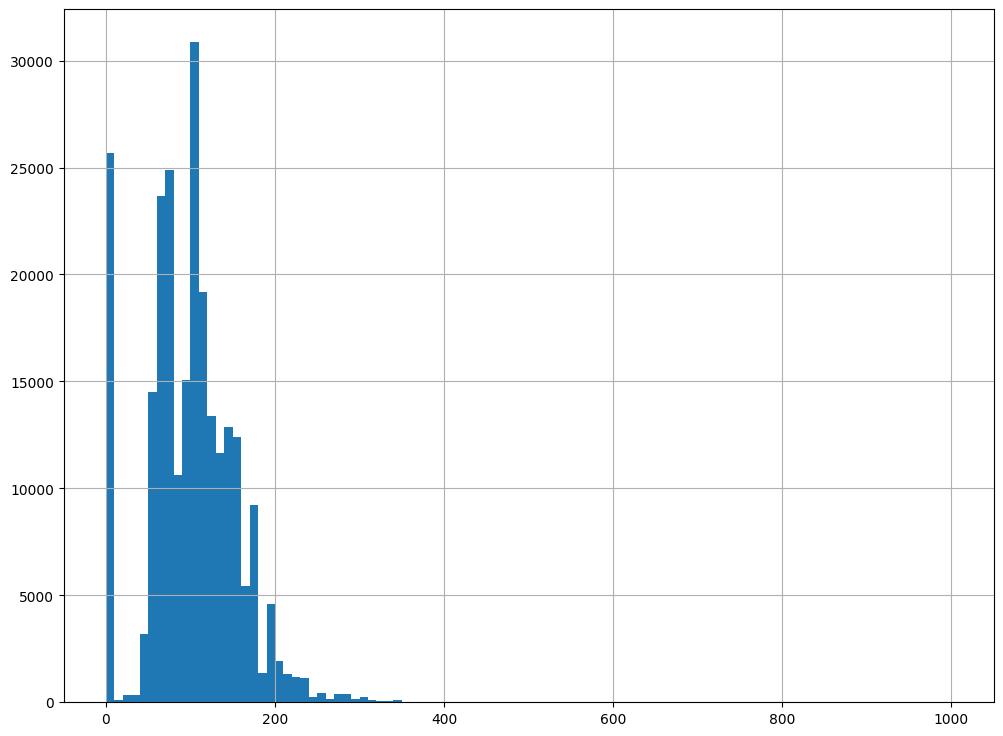

In [24]:
filtred_autos_data = filtred_autos_data.query('Power < 1001')
filtred_autos_data['Power'].hist(bins=100, figsize=(12,9))
filtred_autos_data['Power'].describe()

count    221412.000000
mean        109.878900
std          43.985727
min          25.000000
25%          75.000000
50%         103.000000
75%         136.000000
max         350.000000
Name: Power, dtype: float64

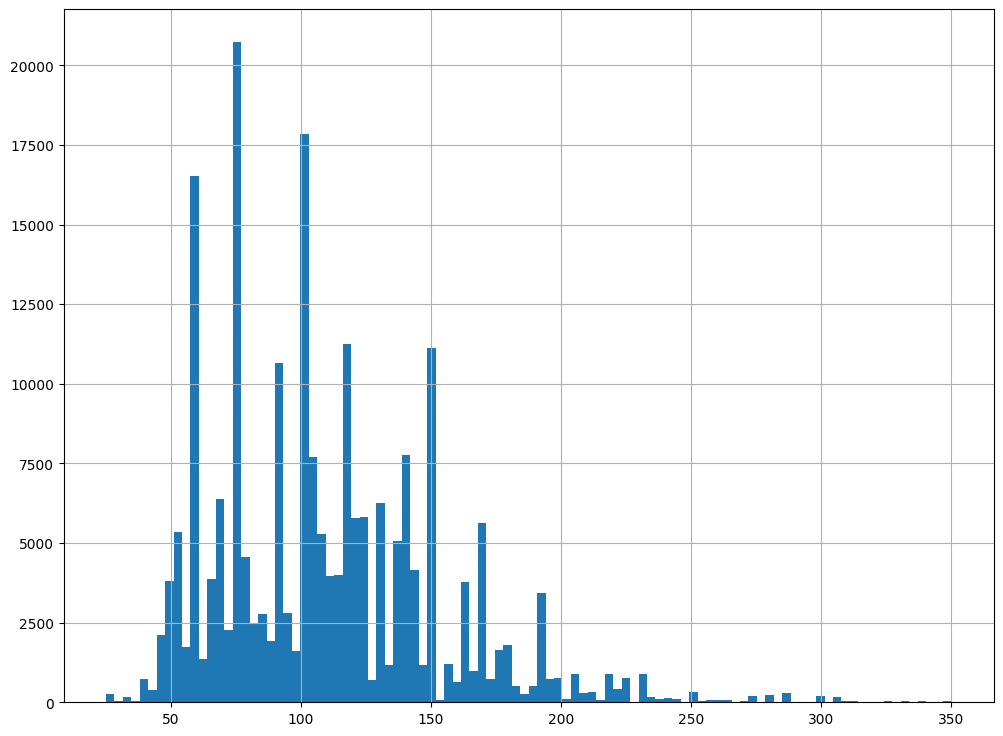

In [25]:
good_autos_data = filtred_autos_data.query('24 < Power < 351')
good_autos_data['Power'].hist(bins=100, figsize=(12,9))
good_autos_data['Power'].describe()

In [26]:
good_autos_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221412 entries, 3 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       221412 non-null  object
 1   Gearbox           221412 non-null  object
 2   Power             221412 non-null  int64 
 3   Kilometer         221412 non-null  int64 
 4   FuelType          221412 non-null  object
 5   Brand             221412 non-null  object
 6   Repaired          221412 non-null  object
 7   RegistrationYear  221412 non-null  int64 
 8   Model             221412 non-null  object
 9   Price             221412 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 18.6+ MB


Посмотрим на наличие пропусков

In [27]:
filtred_autos_data.isnull().sum()

VehicleType         0
Gearbox             0
Power               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
RegistrationYear    0
Model               0
Price               0
dtype: int64

In [28]:
filtred_autos_data.duplicated().sum()

35936

In [29]:
filtred_autos_data = filtred_autos_data.drop_duplicates()
filtred_autos_data

,VehicleType,Gearbox,Power,Kilometer,FuelType,Brand,Repaired,RegistrationYear,Model,Price
0,small,manual,0,150000,petrol,volkswagen,yes,1993,golf,480
3,small,manual,75,150000,petrol,volkswagen,no,2001,golf,1500
4,small,manual,69,90000,gasoline,skoda,no,2008,fabia,3600
5,sedan,manual,102,150000,petrol,bmw,yes,1995,3er,650
6,convertible,manual,109,150000,petrol,peugeot,no,2004,2_reihe,2200
...,...,...,...,...,...,...,...,...,...,...
354361,sedan,auto,150,150000,sedan,alfa_romeo,no,2016,159,5250
354362,sedan,manual,225,150000,petrol,seat,yes,2004,leon,3200
354365,sedan,manual,0,20000,sedan,sonstige_autos,yes,2005,unknown,2200
354366,convertible,auto,101,125000,petrol,smart,no,2000,fortwo,1199


#### Вывод:

- Произведено изучение данных
- Удалены явные дубликаты
- Исключены неинформативные признаки
- Проведено исследование данных после первоначальной предобработки
- Произведена обработка аномалий
- Обработаны пропущенные значения

## Обучение моделей

Проверим 3 модели: Линейная регрессия, CatBoost, LightGBM.


Выделим признаки и целевой показатель.

In [30]:
features = good_autos_data.drop('Price', axis=1)
target = good_autos_data['Price']

Спрятанной тестовой выборки нет. Значит, данные нужно разбить на три части: обучающую, валидационную и тестовую. 

In [31]:
features_train, features_test, target_train, target_test = train_test_split(
    features,target, test_size=0.4, random_state=12345) 

features_test, features_valid, target_test, target_valid = train_test_split(
    features_test,target_test, test_size=0.5, random_state=12345) 

print('Обучающая выборка:', features_train.shape)
print('Валидационная выборка:', features_valid.shape)
print('Тестовая выборка:',features_test.shape)

Обучающая выборка: (132847, 9)
Валидационная выборка: (44283, 9)
Тестовая выборка: (44282, 9)


Проведем кодирование данных методом OHE для Линейной регрессии

In [32]:
ohe_features_LR = features_train.select_dtypes(include='object').columns.to_list()
print(ohe_features_LR)

['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired', 'Model']


In [33]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 132847 entries, 40066 to 348305
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       132847 non-null  object
 1   Gearbox           132847 non-null  object
 2   Power             132847 non-null  int64 
 3   Kilometer         132847 non-null  int64 
 4   FuelType          132847 non-null  object
 5   Brand             132847 non-null  object
 6   Repaired          132847 non-null  object
 7   RegistrationYear  132847 non-null  int64 
 8   Model             132847 non-null  object
dtypes: int64(3), object(6)
memory usage: 10.1+ MB


In [34]:
num_features = features_train.select_dtypes(exclude='object').columns.to_list()
num_features

['Power', 'Kilometer', 'RegistrationYear']

In [35]:
features_train_LR = features_train.copy()
features_valid_LR = features_valid.copy()
features_test_LR = features_test.copy()
print (features_train_LR.shape)
print (features_valid_LR.shape)
print (features_test_LR.shape)

(132847, 9)
(44283, 9)
(44282, 9)


In [36]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)


encoder_ohe.fit(features_train_LR[ohe_features_LR])

features_train_LR[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train_LR[ohe_features_LR])


features_train_LR = features_train_LR.drop(ohe_features_LR, axis=1)


scaler = StandardScaler()


features_train_LR[num_features] = scaler.fit_transform(features_train_LR[num_features])


features_train_LR.head()

,Power,Kilometer,RegistrationYear,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,...,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira
40066,0.346976,0.496086,-0.814275,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
202186,-0.017271,0.496086,0.063734,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
317961,-0.631938,-1.764915,-0.111868,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
338949,-0.017271,0.496086,1.117344,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
264029,-0.791296,0.496086,-0.814275,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Энкодером, который обучен на тренировочной выборке, кодируем валидацинную

In [37]:
features_valid_LR[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_valid_LR[ohe_features_LR])

features_valid_LR = features_valid_LR.drop(ohe_features_LR, axis=1)

features_valid_LR[num_features] = scaler.transform(
    features_valid_LR[num_features]
)

features_valid_LR.head()

,Power,Kilometer,RegistrationYear,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,...,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira
52544,-1.132777,-1.118915,-5.731126,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
290872,0.346976,-0.311415,0.590539,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
263700,1.212062,0.496086,0.941743,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22760,-1.360431,0.496086,-0.638674,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
269395,1.212062,-0.311415,-0.111868,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
features_train_LR.shape, features_valid_LR.shape

((132847, 306), (44283, 306))

In [39]:
(features_train_LR.columns != features_valid_LR.columns).sum()

0

Проведем кодирование данных методом OrdinalEncoder

In [40]:
ore_features = features_train.select_dtypes(include='object').columns.to_list()
print(ore_features)

['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired', 'Model']


In [41]:
num_features_ore = features_train.select_dtypes(exclude='object').columns.to_list()
num_features_ore

['Power', 'Kilometer', 'RegistrationYear']

In [42]:
features_train_ore = features_train.copy()
features_valid_ore = features_valid.copy()
features_test_ore = features_test.copy()

In [43]:
encoder_ore = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [44]:
encoder_ore.fit(features_train_ore[ore_features])

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

Добавляем закодированные признаки в features_train_ore

In [45]:
features_train_ore[
    encoder_ore.get_feature_names_out()
] = encoder_ore.transform(features_train_ore[ore_features])

In [46]:
features_train_ore

,VehicleType,Gearbox,Power,Kilometer,FuelType,Brand,Repaired,RegistrationYear,Model
40066,7.0,1.0,125,150000,8.0,38.0,1.0,1997,167.0
202186,1.0,1.0,109,150000,8.0,25.0,0.0,2002,8.0
317961,5.0,0.0,82,80000,8.0,23.0,0.0,2001,148.0
338949,7.0,1.0,109,150000,4.0,10.0,0.0,2008,102.0
264029,4.0,1.0,75,150000,8.0,11.0,0.0,1997,72.0
...,...,...,...,...,...,...,...,...,...
136624,5.0,1.0,69,60000,8.0,10.0,0.0,2009,125.0
213583,7.0,1.0,129,150000,4.0,10.0,0.0,2006,151.0
208965,5.0,1.0,50,125000,8.0,10.0,1.0,1999,101.0
123655,1.0,1.0,193,125000,8.0,2.0,0.0,1997,11.0


Энкодером, который обучен на тренировочной выборке, кодируем валидационную

In [47]:
features_valid_ore[
    encoder_ore.get_feature_names_out()
] = encoder_ore.transform(features_valid_ore[ore_features])

In [48]:
features_valid_ore.head()

,VehicleType,Gearbox,Power,Kilometer,FuelType,Brand,Repaired,RegistrationYear,Model
52544,3.0,1.0,60,100000,8.0,24.0,0.0,1969,126.0
290872,4.0,1.0,125,125000,12.0,34.0,1.0,2005,119.0
263700,4.0,0.0,163,150000,4.0,31.0,0.0,2007,208.0
22760,5.0,1.0,50,150000,8.0,38.0,0.0,1998,140.0
269395,1.0,0.0,163,125000,8.0,20.0,0.0,2001,201.0


In [49]:
features_train_ore.shape, features_valid_ore.shape

((132847, 9), (44283, 9))

In [50]:
(features_train_ore.columns != features_valid_ore.columns).sum()

0

Энкодером, который обучен на тренировочной выборке, кодируем тестовую

In [51]:
features_test_ore[
    encoder_ore.get_feature_names_out()
] = encoder_ore.transform(features_test_ore[ore_features])

In [52]:
features_test_ore.head()

,VehicleType,Gearbox,Power,Kilometer,FuelType,Brand,Repaired,RegistrationYear,Model
318136,4.0,1.0,177,150000,9.0,2.0,0.0,2008,6.0
242697,4.0,1.0,66,150000,4.0,25.0,0.0,2003,221.0
81908,2.0,0.0,163,125000,8.0,20.0,0.0,2001,58.0
266465,5.0,1.0,135,150000,8.0,25.0,0.0,1999,221.0
135546,4.0,0.0,101,150000,8.0,22.0,1.0,2016,163.0


In [53]:
features_train_ore.shape, features_test_ore.shape

((132847, 9), (44282, 9))

In [54]:
(features_train_ore.columns != features_test_ore.columns).sum()

0

#### Обучим модели

#### 1. Линейная регрессия

In [55]:
%%time
start = time.time()
model_LR = LinearRegression() 
model_LR.fit(features_train_LR,target_train) 
stop = time.time()
training_time_LR = stop - start

CPU times: total: 12.4 s
Wall time: 2.93 s


In [56]:
%%time
start = time.time()
predicions_LR = model_LR.predict(features_valid_LR)
stop = time.time()
training_time_LR_p = stop - start

CPU times: total: 93.8 ms
Wall time: 95 ms


In [57]:
rmse_LR=mean_squared_error(target_valid, predicions_LR)**0.5
print('RMSE модели Линейная Регрессия равна:', rmse_LR)
print('Training time:', training_time_LR)
print('Training time_predict:', training_time_LR_p)

RMSE модели Линейная Регрессия равна: 1349.2551298363655
Training time: 2.928673028945923
Training time_predict: 0.09501910209655762


#### 2. CatBoostRegressor

In [58]:
%%time
start = time.time()
model_Cat = CatBoostRegressor(learning_rate = 0.4, random_state = 12345, verbose = False)

model_Cat.fit(features_train_ore, target_train, eval_set=(features_valid_ore,target_valid))
stop = time.time()
training_time_Cat = stop - start

CPU times: total: 1min 30s
Wall time: 13.9 s


In [59]:
%%time
start = time.time()
predictions_Cat=model_Cat.predict(features_valid_ore)
stop = time.time()
training_time_Cat_p = stop - start

CPU times: total: 93.8 ms
Wall time: 21 ms


In [60]:
rmse_Cat = mean_squared_error(target_valid, predictions_Cat)**0.5 
print("RMSE наилучшей модели на валидационной выборке:", rmse_Cat)
print('Training time:', training_time_Cat)
print('Training time_predict:', training_time_Cat_p)

RMSE наилучшей модели на валидационной выборке: 921.4714315245528
Training time: 13.891149282455444
Training time_predict: 0.021003246307373047


#### 3. Регрессия LGBMRegressor

In [61]:
%%time
start = time.time()
model_LGB = lgbm.sklearn.LGBMRegressor(n_estimators=300, random_state=123, 
                                       learning_rate=0.4, objective='rmse')
model_LGB.fit(features_train_ore, target_train, eval_set=(features_test_ore,
                                                          target_test))
stop = time.time()
training_time_LGB = stop - start

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 562
[LightGBM] [Info] Number of data points in the train set: 132847, number of used features: 9
[LightGBM] [Info] Start training from score 2894.207758
CPU times: total: 4.38 s
Wall time: 1.18 s


In [62]:
%%time
start = time.time()
model_LGB = lgbm.sklearn.LGBMRegressor(n_estimators=300, random_state=12345, learning_rate=0.4, 
                                       objective='rmse')
model_LGB.fit(features_train_ore, target_train, eval_set=(features_valid_ore,target_valid))

stop = time.time()
training_time_LGB = stop - start

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 562
[LightGBM] [Info] Number of data points in the train set: 132847, number of used features: 9
[LightGBM] [Info] Start training from score 2894.207758
CPU times: total: 4.19 s
Wall time: 1.05 s


In [63]:
%%time
start = time.time()
predictions_LGB=model_LGB.predict(features_valid_ore)
stop = time.time()
training_time_LGB_p = stop - start

CPU times: total: 688 ms
Wall time: 177 ms


In [64]:
print(' Гиперпараметры модели:\n',model_LGB)

 Гиперпараметры модели:
 LGBMRegressor(learning_rate=0.4, n_estimators=300, objective='rmse',
              random_state=12345)


In [65]:
rmse_LGB = mean_squared_error(target_valid, predictions_LGB)**0.5 
print("RMSE наилучшей модели на валидационной выборке:", rmse_LGB)
print('Training time:', training_time_LGB)
print('Training time_predict:', training_time_LGB_p)

RMSE наилучшей модели на валидационной выборке: 929.0678001811032
Training time: 1.0522356033325195
Training time_predict: 0.17658495903015137


#### Вывод:
- Применили для категориальных признаков метод OHE и OE
- Рассмотрели три алгоритма классификации: CatBoostRegressor, LGBMRegressor, Линейная регрессия

## Анализ моделей

Соберем результаты моделей в одну таблицу

In [66]:
column=['RMSE модели','Скорость обучения, s','Скорость предсказания, s']

models_total_info = pd.DataFrame(index=['RMSE модели','Скорость обучения, s', 'Скорость предсказания, s'], 
                               columns=['LinearRegression','CatBoostRegressor', 'LightGBM'])
models_total_info['LinearRegression'] = rmse_LR, training_time_LR, training_time_LR_p
models_total_info['CatBoostRegressor'] = rmse_Cat, training_time_Cat, training_time_Cat_p
models_total_info['LightGBM'] = rmse_LGB,training_time_LGB, training_time_LGB_p


In [67]:
display(pd.DataFrame(models_total_info))

,LinearRegression,CatBoostRegressor,LightGBM
RMSE модели,1349.255130,921.471432,929.067800
"Скорость обучения, s",2.928673,13.891149,1.052236
"Скорость предсказания, s",0.095019,0.021003,0.176585


Проверим наилучшую модель CatBoostRegressor на тестовой выборке

In [68]:
%%time
start = time.time()
model_Cat = CatBoostRegressor(learning_rate = 0.4, random_state = 12345, verbose = False)

model_Cat.fit(features_train_ore, target_train, eval_set=(features_test_ore,target_test))
stop = time.time()
training_time_Cat = stop - start

CPU times: total: 1min 32s
Wall time: 14.2 s


In [69]:
%%time
start = time.time()
predictions_Cat= model_Cat.predict(features_test_ore)
stop = time.time()
training_time_Cat_p = stop - start

CPU times: total: 109 ms
Wall time: 21 ms


In [70]:
rmse_Cat_test = mean_squared_error(target_test, predictions_Cat)**0.5 
print("RMSE наилучшей модели на тестовой выборке:", rmse_Cat_test)
print('Training time:', training_time_Cat)
print('Training time_predict:', training_time_Cat_p)

RMSE наилучшей модели на тестовой выборке: 926.3265901021683
Training time: 14.249211072921753
Training time_predict: 0.021004438400268555


Сравним модель на адекватность с константной моделью DummyRegressor

In [71]:
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(features_train_ore, target_train)
predictions_dummy = dummy_model.predict(features_test_ore)
print(mean_squared_error(target_test, predictions_dummy)**0.5 )

2020.664488190611


В ходе данного шага были собраны результаты обучения моделей в одну таблицу, на основании которой можно сделать следующие выводы:
- Модель линейной регрессии обучается быстро, но качество показывает ниже.
- CatBoostRegressor и LightGBM похожи по точности, но отличаются временем обучения и предсказания.

## Итоговый вывод

В ходе работы было выполнено:

1. Загружены данные и проведена предобработка.
2. Выполнено сравнение моделей с использованием различных наборов гиперпараметров.
3. Выбрана лучшая модель по результатам метрики RMSE.
4. Лучшей моделью по трем параметрам качество, скорость обучения и скорость предсказания можно считать CatBoostRegressor. Точность на подготовленных данных выводит её в лидеры . Хотя скорость обучения хуже.